# SGT calculation pure fluids with SAFT-$\gamma$-Mie

In this notebook, the SGT calculations for pure fluids with ```saftgammamie``` EoS are illustrated.

First, all the needed modules are imported.

- numpy: numerical interface and work with arrays
- pandas: to read a file with experimental information
- matplotlib: to plot results
- sgtpy: package with SAFT-$\gamma$-Mie EoS and SGT functions.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sgtpy import component, saftgammamie

Now, pure components are configured and created with the ```component``` function. Then, in order to read the database you need to run the ```component.saftgammamie``` method.

Finally, the function ```saftgammamie``` is used to create the final EoS object.

For this notebook, all calculations are exemplified for pure water.

In [2]:
water = component(GC={'H2O':1})
water.saftgammamie()
eos = saftgammamie(water)

In order to use SGT, we need to fit the influence parameter to experimental data. (Experimental data obtained from NIST webbook)

In [3]:
# Experimental data from NIST webbook
Tsat = np.array([300., 310., 320., 330., 340., 350., 360., 370., 380., 390., 400.])  # K
Psat = np.array([3536.8, 6231.1, 10546., 17213., 27188., 41682., 62194., 90535., 128850., 179640., 245770.]) # Pa
rhol = np.array([55315., 55139., 54919., 54662., 54371., 54049., 53698., 53321., 52918., 52490., 52038.])  # mol/m3
rhov = np.array([1.4204, 2.4237, 3.9778, 6.3042, 9.6808, 14.448, 21.014, 29.859, 41.537, 56.683, 76.014])  # mol/m3
iftexp = np.array([71.686, 70.106, 68.47 , 66.781, 65.04 , 63.248, 61.406, 59.517, 57.581, 55.601, 53.578]) # mN/m

It is necessary to compute the phase equilibria at the given saturation temperatures. This is done with the ```eos.psat``` method.

In [4]:
#Pure component pressure and liquid density
P = np.zeros_like(Psat) 
vl = np.zeros_like(rhol)
vv = np.zeros_like(rhov)

n= len(Psat)
i = 0 
P[i], vl[i], vv[i] = eos.psat(Tsat[i], Psat[i])

for i in range(1, n):
    P[i], vl[i], vv[i] = eos.psat(Tsat[i], Psat[i], v0 = [vl[i-1], vv[i-1]])

rhosaftl = 1/vl
rhosaftv = 1/vv

The saturation pressure and densities are used to fit the influence parameter with the ```fit_cii``` function. This function fits the influence parameter to a temperature dependent polynomial, the default degree is zero (constant `cii`). The obtained polynomial is evaluated with the `numpy.polyval` function.

You can set the influence parameter with the `cii` attribute in the `component` class function.


Finally, the IFT is computed with the ```sgt_pure``` function.

In [5]:
from sgtpy.fit import fit_cii
from sgtpy.sgt import sgt_pure

cii = fit_cii(iftexp, Tsat, P, rhosaftl, rhosaftv, eos, deg=0)
print('fitted influence parameter: ', cii, 'J m^5/mol^2')

water = component(GC={'H2O':1}, cii=cii)
water.saftgammamie()
eos = saftgammamie(water)

# computing IFT in mN/m
ift = np.zeros_like(iftexp)
for i in range(n):
    ift[i] = sgt_pure(rhosaftv[i], rhosaftl[i], Tsat[i], P[i], eos)

fitted influence parameter:  [1.60332448e-20] J m^5/mol^2


The results are plotted below.

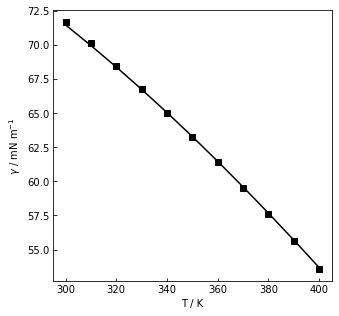

In [6]:
fig = plt.figure(figsize = (5, 5))

ax2 = fig.add_subplot(111)
ax2.plot(Tsat, iftexp, 's', color='k')
ax2.plot(Tsat, ift, color='k')
ax2.set_xlabel('T / K')
ax2.set_ylabel(r'$\gamma$ / mN m$^{-1}$')

ax2.tick_params(direction='in')
# fig.savefig('sgt_pure.pdf')

For further information of any of these functions just run: ```function?```